# Working Notebook
A notebook to work and test different ideas and thoughts in the building of forecast automation. 

In [1]:
# Libraries
import pandas as pd
import numpy as np
import yaml
import os
import pyodbc
import glob
import copy
import traceback
import warnings
warnings.filterwarnings('ignore')
from data_prep_functions import *

In [42]:
import pandas as pd

# Create a DataFrame with three columns
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]})

# Insert column 'B' at index 0 (i.e. the beginning of the DataFrame)
df.insert(0, 'B', df.pop('B'))

print(df)

   B  A  C
0  4  1  7
1  5  2  8
2  6  3  9


In [60]:
region_35 = download_ind_file('35', 'region')
region_35['region'] = 'San Diego'
region_42 = download_ind_file('42', 'region')
region_42['region'] = 'San Diego'

In [9]:
# create both 
def create_both_df(dsid_1, dsid_2, geo_level, to_jdrive):
    df1 = download_ind_file(dsid_1, geo_level)
    df2 = download_ind_file(dsid_2, geo_level)

    # Adjust for common years 
    common_years = common_values(df1['year'], df2['year'])
    df1 = df1[df1['year'].isin(common_years)]
    df2 = df2[df2['year'].isin(common_years)]

    # Adjust for common geography levels 
    common_geographies = common_values(df1[geo_level], df2[geo_level])
    df1 = df1[df1[geo_level].isin(common_geographies)]
    df2 = df2[df2[geo_level].isin(common_geographies)]

    # Set necessary index
    df1 = df1.set_index(['year',geo_level])
    df2 = df2.set_index(['year',geo_level])

    # Merge them based on the index
    output = pd.merge(df1, df2, left_index=True, right_index=True, how='left',suffixes=(f'_{dsid_1}', f'_{dsid_2}'))

    if to_jdrive:
        output.to_csv(f"J:/DataScience/DataQuality/QAQC/forecast_automation/mgra_series_13_outputs_CSV_data/both_files/{geo_level}_both_DS{dsid_1}__DS{dsid_2}_QA.csv", index=True) 

    return output


In [10]:
test = create_both_df('35', '42', geo_level='mgra', to_jdrive=True)
test

taz_35  hs_35  hs_sf_35  hs_mf_35  hs_mh_35  hh_35  hh_sf_35  \
year mgra                                                                  
2016 1        3331     19        19         0         0     18        18   
     2        3331     35        35         0         0     34        34   
     3        3358     52        52         0         0     52        52   
     4        3358     30        30         0         0     30        30   
     5        3358     28        28         0         0     28        28   
...            ...    ...       ...       ...       ...    ...       ...   
2050 22998    1290     92        92         0         0     87        87   
     22999    1290      0         0         0         0      0         0   
     23000    1290    131       131         0         0    126       126   
     23001    1254     85        85         0         0     82        82   
     23002    1254    120        20       100         0    109        17   

            hh_mf_35  hh_mh_35  gq_civ_35  ...  American Indian_42  Asian_42  \
year mgra                                  ...                                 
2016 1             0         0          0  ...                 0.0       1.0   
     2             0         0          0  ...                 0.0       5.0   
     3             0         0          0  ...                 0.0       5.0   
     4             0         0          0  ...                 1.0       0.0   
     5             0         0          0  ...                 1.0       2.0   
...              ...       ...        ...  ...                 ...       ...   
2050 22998         0         0          0  ...                 0.0      94.0   
     22999         0         0          0  ...                 0.0       0.0   
     23000         0         0          0  ...                 1.0      94.0   
     23001         0         0          0  ...                 0.0      56.0   
     23002        92         0          0  ...                 0.0       0.0   

            Black_42  Hispanic_42  Other_42  Pacific Islander_42  \
year mgra                                                          
2016 1           0.0          1.0       1.0                  0.0   
     2           0.0         11.0       0.0                  0.0   
     3           0.0         11.0       0.0                  0.0   
     4           0.0         12.0       0.0                  1.0   
     5           1.0          8.0       0.0                  0.0   
...              ...          ...       ...                  ...   
2050 22998       6.0         39.0       0.0                  0.0   
     22999       0.0          0.0       0.0                  0.0   
     23000       2.0         52.0       3.0                  3.0   
     23001       0.0         55.0       0.0                  0.0   
     23002       0.0          0.0       0.0                  0.0   

            Two or More_42  White_42  Female_42  Male_42  
year mgra                                                 
2016 1                 2.0      36.0       23.0     18.0  
     2                 2.0      63.0       41.0     40.0  
     3                 0.0      95.0       57.0     54.0  
     4                 4.0      55.0       35.0     38.0  
     5                 1.0      50.0       29.0     34.0  
...                    ...       ...        ...      ...  
2050 22998             5.0      77.0      116.0    105.0  
     22999             0.0       0.0        0.0      0.0  
     23000            10.0     117.0      140.0    142.0  
     23001             8.0      74.0       88.0    105.0  
     23002             0.0       0.0        0.0      0.0  

[299026 rows x 289 columns]

In [40]:
def create_diff_df(dsid_1, dsid_2, geo_level, to_jdrive):
    df1 = download_ind_file(dsid_1, geo_level)
    df2 = download_ind_file(dsid_2, geo_level)

    # Adjust for common years 
    common_years = common_values(df1['year'], df2['year'])
    df1 = df1[df1['year'].isin(common_years)]
    df2 = df2[df2['year'].isin(common_years)]

    # Adjust for common geography levels 
    common_geographies = common_values(df1[geo_level], df2[geo_level])
    df1 = df1[df1[geo_level].isin(common_geographies)]
    df2 = df2[df2[geo_level].isin(common_geographies)]

    # Remove other geography related columns 
    wanted_columns = wanted_geography_cols(df1, geo_level) #It doesn't matter which df goes inside
    df1 = df1[wanted_columns]
    df2 = df2[wanted_columns]

    # Common Columns 
    common_columns = common_values(df1.columns, df2.columns)
    df1 = df1[common_columns]
    df2 = df2[common_columns]

    # Set necessary index
    df1 = df1.set_index(['year', geo_level])
    df2 = df2.set_index(['year', geo_level])

    # Drop non-numeric columns 
    df1 = df1.select_dtypes(include='number')
    df2 = df2.select_dtypes(include='number')

    # Ensure columns match up 
    assert sum(~(df1.columns == df2.columns)) == 0

    # Create the diff file 
    output = df1.subtract(df2)

    if to_jdrive:
        output.to_csv(f"J:/DataScience/DataQuality/QAQC/forecast_automation/mgra_series_13_outputs_CSV_data/diff_files/{geo_level}_diff_DS{dsid_1}_minus_DS{dsid_2}_QA.csv", index=True) 

    return output

In [41]:
newest = create_diff_df('35', '42', geo_level='mgra', to_jdrive=True)
newest

1
2
3
4
5
6
7
8
9
10


emp_pvt_hh  collegeenroll  85 and Older  45 to 49  zip09  \
year mgra                                                              
2016 1               0              0           0.0       0.0      0   
     2              -1              0           0.0       0.0      0   
     3              -1              0           0.0       0.0      0   
     4              -1              0           0.0       0.0      0   
     5               0              0           0.0       0.0      0   
...                ...            ...           ...       ...    ...   
2050 22998           0              0           2.0      -9.0      0   
     22999           0              0           0.0       0.0      0   
     23000           0              0         -14.0      -6.0      0   
     23001           0              0          -4.0       4.0      0   
     23002           2              0          14.0      18.0      0   

            high_population  emp_own_occ_dwell_mgmt  75 to 79  emp_religious  \
year mgra                                                                      
2016 1                  0.0                       0       0.0              0   
     2                  0.0                       0       0.0              0   
     3                  0.0                       0       0.0              0   
     4                  0.0                       0       0.0              0   
     5                  0.0                       0       0.0              0   
...                     ...                     ...       ...            ...   
2050 22998             -1.0                       0       3.0              0   
     22999              0.0                       0       0.0              0   
     23000             -9.0                       0      -4.0              0   
     23001             -1.0                       0      -1.0              0   
     23002             10.0                       0      20.0              0   

            5 to 9  ...  vacancy  enrollgrade9to12  elem_population  emp_ag  \
year mgra           ...                                                       
2016 1         0.0  ...      0.0                 0              0.0       0   
     2         0.0  ...      0.0                 0              0.0       0   
     3         0.0  ...      0.0                 0              0.0       0   
     4         0.0  ...      0.0                 0              0.0       0   
     5         0.0  ...      0.0                 0              0.0       0   
...            ...  ...      ...               ...              ...     ...   
2050 22998     1.0  ...      2.0                 0              3.0       0   
     22999     0.0  ...      0.0                 0              0.0       0   
     23000     8.0  ...      0.0                 0             15.0       0   
     23001    12.0  ...      1.0                 0             25.0       0   
     23002     9.0  ...     11.0                 0             25.0       0   

            totint  10 to 14  units  openspaceparkpreserve  hh_mf  \
year mgra                                                           
2016 1         NaN       0.0    0.0                    0.0      0   
     2         NaN       0.0    0.0                    0.0      0   
     3         NaN       0.0    0.0                    0.0      0   
     4         NaN       0.0    0.0                    0.0      0   
     5         NaN       0.0    0.0                    0.0      0   
...            ...       ...    ...                    ...    ...   
2050 22998     NaN      -5.0    2.0                    0.0      0   
     22999     NaN       0.0    0.0                    0.0      0   
     23000     NaN       5.0    0.0                    0.0      0   
     23001     NaN       4.0    2.0                    0.0      0   
     23002     NaN      12.0  120.0                    0.0     92   

            emp_const_bldg_prod  
year mgra                        
2016 1                        0  
     2

In [39]:
assert sum(~(df1.select_dtypes(include='number').columns == df2.select_dtypes(include='number').columns)) == 0

In [21]:
df2

emp_pvt_hh  collegeenroll  85 and Older  45 to 49  zip09  \
year mgra                                                              
2016 1               0              0           2.0       0.0  92103   
     2               1              0           2.0       3.0  92103   
     3               1              0           3.0       5.0  92103   
     4               1              0           1.0       6.0  92103   
     5               0              0           2.0       3.0  92103   
...                ...            ...           ...       ...    ...   
2050 22998           2              0          13.0      17.0  92011   
     22999           0              0           0.0       0.0  92011   
     23000           2              0          25.0      17.0  92011   
     23001           1              0          14.0      10.0  92011   
     23002           0              0           0.0       0.0  92011   

            high_population  emp_own_occ_dwell_mgmt  75 to 79  emp_religious  \
year mgra                                                                      
2016 1                  4.0                       0       1.0              0   
     2                  1.0                       0       3.0              0   
     3                  5.0                       0       7.0              0   
     4                  4.0                       0       3.0              0   
     5                  2.0                       0       4.0              0   
...                     ...                     ...       ...            ...   
2050 22998             11.0                       0       9.0              0   
     22999              0.0                       0       0.0              0   
     23000             16.0                       0      16.0              0   
     23001              9.0                       0       6.0              0   
     23002              0.0                       0       0.0              0   

            5 to 9  ...  vacancy  enrollgrade9to12  elem_population  emp_ag  \
year mgra           ...                                                       
2016 1         0.0  ...      1.0                 0              4.0       0   
     2         7.0  ...      1.0                 0             14.0       0   
     3         2.0  ...      0.0                 0              6.0       0   
     4         3.0  ...      0.0                 0             11.0       0   
     5         4.0  ...      0.0                 0              9.0       0   
...            ...  ...      ...               ...              ...     ...   
2050 22998    11.0  ...      3.0                 0             30.0       0   
     22999     0.0  ...      0.0                 0              0.0       0   
     23000     8.0  ...      5.0                 0             25.0       0   
     23001     6.0  ...      2.0                 0             19.0       0   
     23002     0.0  ...      0.0                 0              0.0       0   

            totint  10 to 14  units  openspaceparkpreserve  hh_mf  \
year mgra                                                           
2016 1         NaN       4.0   19.0                 6.4752      0   
     2         NaN       7.0   35.0                 7.9650      0   
     3         NaN       2.0   52.0                14.5405      0   
     4         NaN       6.0   30.0                 3.0679      0   
     5         NaN       1.0   28.0                 0.4773      0   
...            ...       ...    ...                    ...    ...   
2050 22998     NaN      11.0   90.0                13.6696      0   
     22999     NaN       0.0    0.0                 0.0000      0   
     23000     NaN      10.0  131.0                 2.3259      0   
     23001     NaN       7.0   83.0                 8.0269      0   
     23002     NaN       0.0    0.0                11.4923      0   

            emp_const_bldg_prod  
year mgra                        
2016 1                        0  
     2

In [22]:
df1.columns == df2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [27]:
df1 - df2

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [30]:
df1.dtypes

emp_pvt_hh                 int64
collegeenroll              int64
85 and Older             float64
45 to 49                 float64
zip09                      int64
                          ...   
10 to 14                 float64
units                    float64
openspaceparkpreserve    float64
hh_mf                      int64
emp_const_bldg_prod        int64
Length: 141, dtype: object

In [32]:
df2.select_dtypes(exclude='number')

secondary    unified School Data Present elementary
year mgra                                                     
2016 1           NaN  San Diego        Only Unified        NaN
     2           NaN  San Diego        Only Unified        NaN
     3           NaN  San Diego        Only Unified        NaN
     4           NaN  San Diego        Only Unified        NaN
     5           NaN  San Diego        Only Unified        NaN
...              ...        ...                 ...        ...
2050 22998       NaN   Carlsbad        Only Unified        NaN
     22999       NaN   Carlsbad        Only Unified        NaN
     23000       NaN   Carlsbad        Only Unified        NaN
     23001       NaN   Carlsbad        Only Unified        NaN
     23002       NaN   Carlsbad        Only Unified        NaN

[299026 rows x 4 columns]

In [50]:
common_values(region_35.columns, region_42.columns)

['year',
 'taz',
 'hs',
 'hs_sf',
 'hs_mf',
 'hs_mh',
 'hh',
 'hh_sf',
 'hh_mf',
 'hh_mh',
 'gq_civ',
 'gq_mil',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6',
 'i7',
 'i8',
 'i9',
 'i10',
 'hhs',
 'pop',
 'hhp',
 'emp_ag',
 'emp_const_non_bldg_prod',
 'emp_const_non_bldg_office',
 'emp_utilities_prod',
 'emp_utilities_office',
 'emp_const_bldg_prod',
 'emp_const_bldg_office',
 'emp_mfg_prod',
 'emp_mfg_office',
 'emp_whsle_whs',
 'emp_trans',
 'emp_retail',
 'emp_prof_bus_svcs',
 'emp_prof_bus_svcs_bldg_maint',
 'emp_pvt_ed_k12',
 'emp_pvt_ed_post_k12_oth',
 'emp_health',
 'emp_personal_svcs_office',
 'emp_amusement',
 'emp_hotel',
 'emp_restaurant_bar',
 'emp_personal_svcs_retail',
 'emp_religious',
 'emp_pvt_hh',
 'emp_state_local_gov_ent',
 'emp_fed_non_mil',
 'emp_fed_mil',
 'emp_state_local_gov_blue',
 'emp_state_local_gov_white',
 'emp_public_ed',
 'emp_own_occ_dwell_mgmt',
 'emp_fed_gov_accts',
 'emp_st_lcl_gov_accts',
 'emp_cap_accts',
 'emp_total',
 'enrollgradekto8',
 'enrollgrad

In [11]:
region_35['year']

0     2016
1     2018
2     2020
3     2023
4     2025
5     2026
6     2029
7     2030
8     2032
9     2035
10    2040
11    2045
12    2050
Name: year, dtype: int64

In [13]:
region_41

,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,gq_civ,gq_mil,...,American Indian,Asian,Black,Hispanic,Other,Pacific Islander,Two or More,White,Female,Male
0,1190554,717626,430716,42212,1134848,687509,407158,40181,63014,43285,...,15013.0,359333.0,147802.0,1133247.0,7292.0,14569.0,110607.0,1521647.0,1645779.0,1663731.0
1,1205852,723209,440536,42107,1147635,692445,415174,40016,69372,46797,...,21784.0,428178.0,168445.0,1093476.0,7984.0,14263.0,108340.0,1510962.0,1662764.0,1690668.0
2,1226462,730452,453903,42107,1166240,699024,427131,40085,72056,48307,...,22215.0,447279.0,168786.0,1110869.0,8162.0,14275.0,111793.0,1500570.0,1676159.0,1707790.0
3,1262957,739359,481491,42107,1197072,705805,451119,40148,73875,50572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1288217,746460,499650,42107,1219745,711809,467740,40196,74447,51327,...,23373.0,495028.0,169353.0,1171491.0,8653.0,14428.0,121897.0,1466600.0,1713613.0,1757210.0
5,1300847,749930,508810,42107,1231007,714753,476048,40206,74733,51327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1338737,758815,537815,42107,1264151,722291,501623,40237,75591,51327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1351367,760811,548449,42107,1274948,724080,510627,40241,75877,51327,...,24486.0,540682.0,169240.0,1238717.0,9029.0,14574.0,132217.0,1423517.0,1755115.0,1797347.0
8,1376162,764402,569653,42107,1296193,727144,528802,40247,76043,51327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1409867,769000,598760,42107,1327588,731358,555975,40255,76292,51327,...,25465.0,583935.0,168490.0,1303640.0,9302.0,14562.0,142326.0,1372597.0,1791708.0,1828609.0


In [12]:
region_41['year']

KeyError: 'year'

In [26]:
common_values(region_35['year'], region_42['year'])

[]

In [25]:
region_35['year'][3] region_42['year'][3]

True

In [23]:
region_42['year'][3]

2023

In [3]:
a = region_foldup('39', to_jdrive=True)
a

hs   hs_sf   hs_mf  hs_mh       hh   hh_sf   hh_mf  \
region    year                                                            
San Diego 2016  1190554  717626  430716  42212  1134848  687509  407158   
          2018  1205852  722026  441719  42107  1147635  691575  416064   
          2020  1226462  726659  457696  42107  1166240  695807  430402   
          2023  1262957  734381  486469  42107  1197072  701788  455125   
          2025  1288217  739817  506293  42107  1219745  706137  473414   
          2026  1300847  742347  516393  42107  1231007  708526  482277   
          2029  1338737  748717  547913  42107  1264151  714546  509381   
          2030  1351367  750795  558465  42107  1274948  716282  518441   
          2032  1376162  754407  579648  42107  1296193  719069  536891   
          2035  1409867  760440  607320  42107  1327588  724332  563015   
          2040  1443635  767274  634254  42107  1348283  728270  579770   
          2045  1460856  769807  648942  42107  1364815  730361  594211   
          2050  1471300  771308  657885  42107  1374841  731588  603010   

                hh_mh  gq_civ  gq_mil  ...  American Indian     Asian  \
region    year                         ...                              
San Diego 2016  40181   63014   43285  ...          15013.0  359333.0   
          2018  39996   69372   46797  ...          21777.0  428225.0   
          2020  40031   72056   48307  ...          22201.0  447304.0   
          2023  40159   73875   50572  ...              0.0       0.0   
          2025  40194   74447   51327  ...          23405.0  495001.0   
          2026  40204   74733   51327  ...              0.0       0.0   
          2029  40224   75591   51327  ...              0.0       0.0   
          2030  40225   75877   51327  ...          24470.0  540665.0   
          2032  40233   76043   51327  ...              0.0       0.0   
          2035  40241   76292   51327  ...          25468.0  583963.0   
          2040  40243   76292   51327  ...          26502.0  627064.0   
          2045  40243   76292   51327  ...          27347.0  669324.0   
          2050  40243   76292   51327  ...          27966.0  709124.0   

                   Black   Hispanic    Other  Pacific Islander  Two or More  \
region    year                                                                
San Diego 2016  147802.0  1133247.0   7292.0           14569.0     110607.0   
          2018  168455.0  1093476.0   7944.0           14269.0     108336.0   
          2020  168834.0  1110869.0   8204.0           14285.0     111753.0   
          2023       0.0        0.0      0.0               0.0          0.0   
          2025  169359.0  1171494.0   8709.0           14444.0     121863.0   
          2026       0.0        0.0      0.0               0.0          0.0   
          2029       0.0        0.0      0.0               0.0          0.0   
          2030  169278.0  1238717.0   9133.0           14574.0     132151.0   
          2032       0.0        0.0      0.0               0.0          0.0   
          2035  168558.0  1303640.0   9518.0           14578.0     142254.0   
          2040  166869.0  1369592.0   9788.0           14447.0     151630.0   
          2045  164304.0  1432019.0  10090.0           14200.0     160512.0   
          2050  160236.0  1485512.0  10224.0           13957.0     168382.0   

                    White     Female       Male  
region    year                                   
San Diego 2016  1521647.0  1645779.0  1663731.0  
          2018  1510954.0  1662764.0  1690672.0  
          2020  1500504.0  1676160.0  1707794.0  
          2023        0.0        0.0        0.0  
          2025  1466573.0  1713620.0  1757228.0  
          2026        0.0        0.0        0.0  
          2029        0.0        0.0        0.0  
          2030  1423494.0  1755123.0  1797359.0  
          2032        0.0        0.0        0.0  
          2035  1372360.0  1791716.0  1828623.0  
          204

In [6]:
a.reset_index(drop=False).dtypes

region               object
year                  int64
hs                    int64
hs_sf                 int64
hs_mf                 int64
                     ...   
Pacific Islander    float64
Two or More         float64
White               float64
Female              float64
Male                float64
Length: 142, dtype: object

In [2]:
# Download some data
mgra_ds42 = pd.read_csv(r'J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\aggregated_data\mgra_DS42_ind_QA.csv')

In [3]:
region_foldup(mgra_ds42)

hs   hs_sf   hs_mf  hs_mh       hh   hh_sf   hh_mf  \
region    year                                                            
San Diego 2016  1190554  717626  430716  42212  1134848  687509  407158   
          2018  1205852  721197  442548  42107  1147635  690662  416984   
          2020  1226462  722838  461517  42107  1166240  692841  433380   
          2023  1262957  726724  494126  42107  1197072  696655  460274   
          2025  1288217  728371  517739  42107  1219745  698560  481026   
          2026  1300847  729354  529386  42107  1231007  699431  491412   
          2029  1338737  730943  565687  42107  1264151  701159  522824   
          2030  1351367  731412  577848  42107  1274948  701620  533159   
          2032  1376162  732534  601521  42107  1296193  702540  553480   
          2035  1409867  734934  632826  42107  1327588  704257  583158   
          2040  1443635  737896  663632  42107  1348283  706499  601608   
          2045  1460856  738005  680744  42107  1364815  707948  616679   
          2050  1471300  738133  691060  42107  1374841  708722  625915   

                hh_mh  gq_civ  gq_mil  ...  American Indian     Asian  \
region    year                         ...                              
San Diego 2016  40181   63014   43285  ...          15013.0  359333.0   
          2018  39989   69372   46797  ...          21780.0  428237.0   
          2020  40019   72056   48307  ...          22212.0  447328.0   
          2023  40143   73875   50572  ...              0.0       0.0   
          2025  40159   74447   51327  ...          23405.0  495065.0   
          2026  40164   74733   51327  ...              0.0       0.0   
          2029  40168   75591   51327  ...              0.0       0.0   
          2030  40169   75877   51327  ...          24461.0  540713.0   
          2032  40173   76043   51327  ...              0.0       0.0   
          2035  40173   76292   51327  ...          25475.0  583877.0   
          2040  40176   76292   51327  ...          26525.0  626972.0   
          2045  40188   76292   51327  ...          27360.0  669180.0   
          2050  40204   76292   51327  ...          27975.0  708905.0   

                   Black   Hispanic   Other  Pacific Islander  Two or More  \
region    year                                                               
San Diego 2016  147802.0  1133247.0  7292.0           14569.0     110607.0   
          2018  168467.0  1093476.0  7880.0           14271.0     108301.0   
          2020  168837.0  1110869.0  8072.0           14281.0     111771.0   
          2023       0.0        0.0     0.0               0.0          0.0   
          2025  169421.0  1171494.0  8488.0           14442.0     121859.0   
          2026       0.0        0.0     0.0               0.0          0.0   
          2029       0.0        0.0     0.0               0.0          0.0   
          2030  169354.0  1238717.0  8924.0           14583.0     132110.0   
          2032       0.0        0.0     0.0               0.0          0.0   
          2035  168652.0  1303640.0  9313.0           14575.0     142199.0   
          2040  166946.0  1369592.0  9579.0           14456.0     151599.0   
          2045  164404.0  1432019.0  9745.0           14195.0     160536.0   
          2050  160422.0  1485517.0  9884.0           13945.0     168435.0   

                    White     Female       Male  
region    year                                   
San Diego 2016  1521647.0  1645779.0  1663731.0  
          2018  1511024.0  1662764.0  1690672.0  
          2020  1500584.0  1676160.0  1707794.0  
          2023        0.0        0.0        0.0  
          2025  1466674.0  1713620.0  1757228.0  
          2026        0.0        0.0        0.0  
          2029        0.0        0.0        0.0  
          2030  1423623.0  1755124.0  1797361.0  
          2032        0.0        0.0        0.0  
          2035  1372617.0  1791723.0  1828625.0  
          2040  1310507.0  1

In [20]:
def wanted_geography_cols(df, wanted_geo_level):
    """Returns a list of columns that do not include unwanted geography levels."""
    geography_levels = ['mgra', 'cpa', 'jurisdiction', 'luz_id', 'taz', 'region']
    geography_levels.remove(wanted_geo_level)

    return [col for col in df.columns if col not in geography_levels]

In [22]:
mgra_ds42[wanted_geography_cols(mgra_ds42, 'region')]

,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,gq_civ,gq_mil,...,Asian,Black,Hispanic,Other,Pacific Islander,Two or More,White,Female,Male,region
0,19,19,0,0,18,18,0,0,0,0,...,1.0,0.0,1.0,1.0,0.0,2.0,36.0,23.0,18.0,San Diego
1,35,35,0,0,34,34,0,0,0,0,...,5.0,0.0,11.0,0.0,0.0,2.0,63.0,41.0,40.0,San Diego
2,52,52,0,0,52,52,0,0,0,0,...,5.0,0.0,11.0,0.0,0.0,0.0,95.0,57.0,54.0,San Diego
3,30,30,0,0,30,30,0,0,0,0,...,0.0,0.0,12.0,0.0,1.0,4.0,55.0,35.0,38.0,San Diego
4,28,28,0,0,28,28,0,0,0,0,...,2.0,1.0,8.0,0.0,0.0,1.0,50.0,29.0,34.0,San Diego
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299021,90,90,0,0,87,87,0,0,0,0,...,94.0,6.0,39.0,0.0,0.0,5.0,77.0,116.0,105.0,San Diego
299022,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,San Diego
299023,131,131,0,0,126,126,0,0,0,0,...,94.0,2.0,52.0,3.0,3.0,10.0,117.0,140.0,142.0,San Diego
299024,83,83,0,0,81,81,0,0,0,0,...,56.0,0.0,55.0,0.0,0.0,8.0,74.0,88.0,105.0,San Diego


In [23]:
def region_foldup(df):
    df['region'] = 'San Diego'
    df = df.groupby(['region', 'year']).sum()
    return df[wanted_geography_cols(df, 'region')]

In [24]:
region_foldup(mgra_ds42)

hs   hs_sf   hs_mf  hs_mh       hh   hh_sf   hh_mf  \
region    year                                                            
San Diego 2016  1190554  717626  430716  42212  1134848  687509  407158   
          2018  1205852  721197  442548  42107  1147635  690662  416984   
          2020  1226462  722838  461517  42107  1166240  692841  433380   
          2023  1262957  726724  494126  42107  1197072  696655  460274   
          2025  1288217  728371  517739  42107  1219745  698560  481026   
          2026  1300847  729354  529386  42107  1231007  699431  491412   
          2029  1338737  730943  565687  42107  1264151  701159  522824   
          2030  1351367  731412  577848  42107  1274948  701620  533159   
          2032  1376162  732534  601521  42107  1296193  702540  553480   
          2035  1409867  734934  632826  42107  1327588  704257  583158   
          2040  1443635  737896  663632  42107  1348283  706499  601608   
          2045  1460856  738005  680744  42107  1364815  707948  616679   
          2050  1471300  738133  691060  42107  1374841  708722  625915   

                hh_mh  gq_civ  gq_mil  ...  American Indian     Asian  \
region    year                         ...                              
San Diego 2016  40181   63014   43285  ...          15013.0  359333.0   
          2018  39989   69372   46797  ...          21780.0  428237.0   
          2020  40019   72056   48307  ...          22212.0  447328.0   
          2023  40143   73875   50572  ...              0.0       0.0   
          2025  40159   74447   51327  ...          23405.0  495065.0   
          2026  40164   74733   51327  ...              0.0       0.0   
          2029  40168   75591   51327  ...              0.0       0.0   
          2030  40169   75877   51327  ...          24461.0  540713.0   
          2032  40173   76043   51327  ...              0.0       0.0   
          2035  40173   76292   51327  ...          25475.0  583877.0   
          2040  40176   76292   51327  ...          26525.0  626972.0   
          2045  40188   76292   51327  ...          27360.0  669180.0   
          2050  40204   76292   51327  ...          27975.0  708905.0   

                   Black   Hispanic   Other  Pacific Islander  Two or More  \
region    year                                                               
San Diego 2016  147802.0  1133247.0  7292.0           14569.0     110607.0   
          2018  168467.0  1093476.0  7880.0           14271.0     108301.0   
          2020  168837.0  1110869.0  8072.0           14281.0     111771.0   
          2023       0.0        0.0     0.0               0.0          0.0   
          2025  169421.0  1171494.0  8488.0           14442.0     121859.0   
          2026       0.0        0.0     0.0               0.0          0.0   
          2029       0.0        0.0     0.0               0.0          0.0   
          2030  169354.0  1238717.0  8924.0           14583.0     132110.0   
          2032       0.0        0.0     0.0               0.0          0.0   
          2035  168652.0  1303640.0  9313.0           14575.0     142199.0   
          2040  166946.0  1369592.0  9579.0           14456.0     151599.0   
          2045  164404.0  1432019.0  9745.0           14195.0     160536.0   
          2050  160422.0  1485517.0  9884.0           13945.0     168435.0   

                    White     Female       Male  
region    year                                   
San Diego 2016  1521647.0  1645779.0  1663731.0  
          2018  1511024.0  1662764.0  1690672.0  
          2020  1500584.0  1676160.0  1707794.0  
          2023        0.0        0.0        0.0  
          2025  1466674.0  1713620.0  1757228.0  
          2026        0.0        0.0        0.0  
          2029        0.0        0.0        0.0  
          2030  1423623.0  1755124.0  1797361.0  
          2032        0.0        0.0        0.0  
          2035  1372617.0  1791723.0  1828625.0  
          2040  1310507.0  1

In [11]:
mgra_ds42['Region'] = 

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,American Indian,Asian,Black,Hispanic,Other,Pacific Islander,Two or More,White,Female,Male
0,1,3331,19,19,0,0,18,18,0,0,...,0.0,1.0,0.0,1.0,1.0,0.0,2.0,36.0,23.0,18.0
1,2,3331,35,35,0,0,34,34,0,0,...,0.0,5.0,0.0,11.0,0.0,0.0,2.0,63.0,41.0,40.0
2,3,3358,52,52,0,0,52,52,0,0,...,0.0,5.0,0.0,11.0,0.0,0.0,0.0,95.0,57.0,54.0
3,4,3358,30,30,0,0,30,30,0,0,...,1.0,0.0,0.0,12.0,0.0,1.0,4.0,55.0,35.0,38.0
4,5,3358,28,28,0,0,28,28,0,0,...,1.0,2.0,1.0,8.0,0.0,0.0,1.0,50.0,29.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299021,22998,1290,90,90,0,0,87,87,0,0,...,0.0,94.0,6.0,39.0,0.0,0.0,5.0,77.0,116.0,105.0
299022,22999,1290,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299023,23000,1290,131,131,0,0,126,126,0,0,...,1.0,94.0,2.0,52.0,3.0,3.0,10.0,117.0,140.0,142.0
299024,23001,1254,83,83,0,0,81,81,0,0,...,0.0,56.0,0.0,55.0,0.0,0.0,8.0,74.0,88.0,105.0


In [10]:
def hhs_adjustment(df):
    """Adjusts hhs values"""
    df['hhs'] = df['hhp']/df['hh']
    return df

In [9]:
new

,hh,hhp,calc
0,18,41,2.277778
1,34,81,2.382353
2,52,111,2.134615
3,30,73,2.433333
4,28,63,2.250000
...,...,...,...
299021,87,221,2.540230
299022,0,0,NaN
299023,126,282,2.238095
299024,81,193,2.382716


In [8]:
new = mgra_ds42[['hh', 'hhp']]
new['calc'] = new['hhp']/new['hh']
round(new['calc'], 3)

0         2.278
1         2.382
2         2.135
3         2.433
4         2.250
          ...  
299021    2.540
299022      NaN
299023    2.238
299024    2.383
299025      NaN
Name: calc, Length: 299026, dtype: float64

In [5]:
0/0

ZeroDivisionError: division by zero

In [3]:
ds99_41_diff = pd.read_csv(r'J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\diff_files\mgra_diff_DS99_minus_DS41_QA.csv')

In [2]:
# Localise with . files 
if os.getcwd().split('\\')[-1] == 'scripts':
    config_filename = '../config_files/ds_config.yml'
else:
    config_filename = './config_files/ds_config.yml'

In [3]:
with open('ds_config_2.yml', "r") as yml_file:
    config = yaml.safe_load(yml_file)

In [7]:
config['46'].keys()

dict_keys(['T_Drive_files', 'Household_Files', 'Person_Files', 'forecast_ID'])

In [5]:
config['46']['Household_Files']

{'DS46_households_2016': 'T:/socioec/Current_Projects/XPEF40/abm_csv/households_2016_01.csv',
 'DS46_households_2018': 'T:/socioec/Current_Projects/XPEF40/abm_csv/households_2018_01.csv',
 'DS46_households_2020': 'T:/socioec/Current_Projects/XPEF40/abm_csv/households_2020_01.csv',
 'DS46_households_2023': 'T:/socioec/Current_Projects/XPEF40/abm_csv/households_2023_01.csv',
 'DS46_households_2025': 'T:/socioec/Current_Projects/XPEF40/abm_csv/households_2025_01.csv',
 'DS46_households_2026': 'T:/socioec/Current_Projects/XPEF40/abm_csv/households_2026_01.csv',
 'DS46_households_2029': 'T:/socioec/Current_Projects/XPEF40/abm_csv/households_2029_01.csv',
 'DS46_households_2030': 'T:/socioec/Current_Projects/XPEF40/abm_csv/households_2030_01.csv',
 'DS46_households_2032': 'T:/socioec/Current_Projects/XPEF40/abm_csv/households_2032_01.csv',
 'DS46_households_2035': 'T:/socioec/Current_Projects/XPEF40/abm_csv/households_2035_01.csv',
 'DS46_households_2040': 'T:/socioec/Current_Projects/XPEF40

In [2]:
def download_and_concat_Tdrive_files(dsid, desired_data):
    """
    Downloads all of the files from T drive for this particular dsid and adds the year
    desired_data input options: 'T_Drive_files', 'Household_Files', 'Person_Files' 
    
    """

    with open('ds_config_2.yml', "r") as yml_file:
        config = yaml.safe_load(yml_file)

    concatonated_dfs = pd.DataFrame()

    for key, path in config[dsid][desired_data].items():
        temp_df = pd.read_csv(path)
        temp_df['year'] = key[-4:]
        concatonated_dfs = pd.concat([concatonated_dfs, temp_df])

    return concatonated_dfs

In [10]:
ds46_mgra_data = download_and_concat_Tdrive_files('46', 'T_Drive_files')
ds46_mgra_data

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations,year
0,1,3331,19,19,0,0,18,18,0,0,...,1,27,3.7997,16.615444,12.961482,16.615444,10,0,0,2016
1,2,3331,35,35,0,0,34,34,0,0,...,1,27,3.9761,19.519185,19.519185,19.519185,10,0,0,2016
2,3,3358,52,52,0,0,52,52,0,0,...,1,27,4.1939,27.845124,26.867938,27.845124,10,0,0,2016
3,4,3358,30,30,0,0,30,30,0,0,...,1,27,4.2782,7.976178,7.976178,7.976178,10,0,0,2016
4,5,3358,28,28,0,0,28,28,0,0,...,1,27,4.0062,7.072502,7.063693,7.072502,10,0,0,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22997,22998,1290,90,90,0,0,87,87,0,0,...,1,1,2.6193,41.241522,26.863578,41.241522,120,0,0,2050
22998,22999,1290,0,0,0,0,0,0,0,0,...,1,1,2.3703,35.842780,30.635095,35.842780,120,0,0,2050
22999,23000,1290,131,131,0,0,126,126,0,0,...,1,1,2.1721,28.735275,16.109816,28.735275,120,0,0,2050
23000,23001,1254,83,83,0,0,81,81,0,0,...,1,1,2.7063,41.006144,28.126056,41.006144,120,0,0,2050


In [12]:
ds46_mgra_data.to_csv(r'J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\aggregated_data\mgra_DS46_ind_QA.csv')

In [9]:
household_data_ds46 = download_and_concat_Tdrive_files('46', 'Household_Files')
household_data_ds46

,hhid,household_serial_no,taz,mgra,hinccat1,hinc,hworkers,veh,persons,hht,bldgsz,unittype,version,poverty,year
0,1,0,3458,47,5,294757,1,0,2,1,2,0,0,22.364,2016
1,2,0,3407,10,5,210480,1,0,2,1,2,0,0,15.970,2016
2,3,0,3458,16,5,236389,0,0,2,3,2,0,0,15.728,2016
3,4,0,3379,27,4,121977,2,0,2,2,2,0,0,8.353,2016
4,5,0,3358,3,4,104512,2,0,2,7,2,0,0,7.157,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455750,1455751,0,3144,6055,1,14000,0,0,1,0,9,1,0,1.234,2050
1455751,1455752,0,3144,6055,1,14000,0,0,1,0,9,1,0,1.234,2050
1455752,1455753,0,3144,6055,1,14000,0,0,1,0,9,1,0,1.234,2050
1455753,1455754,0,3144,6055,1,14000,1,0,1,0,9,1,0,1.234,2050


In [2]:
def number_of_households_from_households_dataset(dsid, gq_only, no_gq):
    '''Downloads and aggregates population data from the households dataset depending on GQ preference.'''
    # From households file
    household_file_all = download_and_concat_Tdrive_files(
        dsid, 'Household_Files')
    household_file_subset = household_file_all[['year', 'mgra', 'hhid']]
    household_file_subset['year'] = pd.to_numeric(
        household_file_subset['year'])

    if (gq_only == no_gq) & (gq_only == False):
        # GQ and Non-GQ Person Comparison
        household_count_household_file_all = household_file_subset.groupby(
            ['year', 'mgra']).count().reset_index()
        household_count_household_file_all.columns = [
            'year', 'mgra', 'house_count_household_file']
        return household_count_household_file_all
    elif gq_only == True:
        # Just GQ Population Comparison
        household_file_gq_only = household_file_subset[household_file_all['unittype'] == 1]
        household_count_household_file_gq_only = household_file_gq_only.groupby(
            ['year', 'mgra']).count().reset_index()
        household_count_household_file_gq_only.columns = [
            'year', 'mgra', 'house_count_household_file']
        return household_count_household_file_gq_only
    else:
        # Just Non-GQ Person Comparison
        household_file_no_gq = household_file_subset[household_file_all['unittype'] == 0]
        household_count_household_file_no_gq = household_file_no_gq.groupby(
            ['year', 'mgra']).count().reset_index()
        household_count_household_file_no_gq.columns = [
            'year', 'mgra', 'house_count_household_file']
        return household_count_household_file_no_gq

In [74]:
a = number_of_households_from_households_dataset('46', gq_only=False, no_gq=True)
a

,year,mgra,house_count_household_file
0,2016,1,18
1,2016,2,34
2,2016,3,52
3,2016,4,30
4,2016,5,28
...,...,...,...
237975,2050,22996,103
237976,2050,22998,87
237977,2050,23000,126
237978,2050,23001,81


In [3]:
def household_number_comparison_houseolds_and_input_files(dsid, to_jdrive):
    '''Compare number of households between input files and households dataset. Only at the 'No GQ' level.'''
    # Bring in input files and process
    mgra_data = pd.read_csv(rf'J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\aggregated_data\mgra_DS{dsid}_ind_QA.csv', usecols=[
                            'year', 'mgra', 'hh'])
    mgra_data = mgra_data.rename(columns={'hh': 'hh_count_input_files'})

    output = number_of_households_from_households_dataset(dsid, gq_only=False, no_gq=True).merge(
        mgra_data, how='left', on=['year', 'mgra'])
    output = output[['year', 'mgra','house_count_household_file', 'hh_count_input_files']]
    output['Diff'] = output['house_count_household_file'] - output['house_count_household_file']
    if to_jdrive:
        output.to_csv(
            rf"J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\other_outputs\mgra_households_dataset_hh_count_comparison_no_GQ_DS{dsid}_QA.csv", index=False)
    return output

In [6]:
output = household_number_comparison_houseolds_and_input_files('46', to_jdrive=False)
output

NameError: name 'download_and_concat_Tdrive_files' is not defined

In [58]:
household_data_ds46[household_data_ds46['mgra'] == 22999]

,hhid,household_serial_no,taz,mgra,hinccat1,hinc,hworkers,veh,persons,hht,bldgsz,unittype,version,poverty,year


In [16]:
household_data_ds46[['year', 'mgra', 'persons']][household_data_ds46['unittype'] == 1]

,year,mgra,persons
1134848,2016,22705,1
1134849,2016,22705,1
1134850,2016,22705,1
1134851,2016,22705,1
1134852,2016,22705,1
...,...,...,...
1455750,2050,6055,1
1455751,2050,6055,1
1455752,2050,6055,1
1455753,2050,6055,1


In [14]:
# Persons Comparison (using household file)

# From households file 
household_file_all = download_and_concat_Tdrive_files('46', 'Household_Files')

# GQ and Non-GQ Person Comparison 
population_household_file_all = household_file_all[['year', 'mgra', 'persons']].groupby(['year', 'mgra']).sum().reset_index()
population_household_file_all.columns = ['year', 'mgra', 'pop_count_household_file']

# Just GQ Population Comparison 
household_file_gq_only = household_file_all[['year', 'mgra', 'persons']][household_file_all['unittype'] == 1]
population_household_file_gq_only = household_file_gq_only.groupby(['year', 'mgra']).sum().reset_index()
population_household_file_gq_only.columns = ['year', 'mgra', 'pop_count_household_file']


# Just Non-GQ Person Comparison 
household_file_no_gq = household_file_all[['year', 'mgra', 'persons']][household_file_all['unittype'] == 0]
population_household_file_no_gq = household_file_no_gq.groupby(['year', 'mgra']).sum().reset_index()
population_household_file_no_gq.columns = ['year', 'mgra', 'pop_count_household_file']


persons
year mgra          
2016 1           41
     2           81
     3          111
     4           73
     5           63
...             ...
2050 22996      236
     22998      196
     23000      307
     23001      184
     23002      262

[237980 rows x 1 columns]

In [23]:
(2==2)

True

In [26]:
a = False
b = False

In [31]:
(a==b)&(a==False)

True

In [30]:
(a==False)

True

In [5]:
def population_from_households_dataset(dsid, gq_only, no_gq):
    '''Downloads and aggregates population data from the households dataset depending on GQ preference.'''
    # From households file 
    household_file_all = download_and_concat_Tdrive_files(dsid, 'Household_Files')
    household_file_subset = household_file_all[['year', 'mgra', 'persons']]
    household_file_subset['year'] = pd.to_numeric(household_file_subset['year'])

    if (gq_only==no_gq)&(gq_only==False):
        # GQ and Non-GQ Person Comparison 
        population_household_file_all = household_file_subset.groupby(['year', 'mgra']).sum().reset_index()
        population_household_file_all.columns = ['year', 'mgra', 'pop_count_household_file']
        return population_household_file_all
    elif gq_only == True:
        # Just GQ Population Comparison 
        household_file_gq_only = household_file_subset[household_file_all['unittype'] == 1]
        population_household_file_gq_only = household_file_gq_only.groupby(['year', 'mgra']).sum().reset_index()
        population_household_file_gq_only.columns = ['year', 'mgra', 'pop_count_household_file']
        return population_household_file_gq_only
    else:
        # Just Non-GQ Person Comparison 
        household_file_no_gq = household_file_subset[household_file_all['unittype'] == 0]
        population_household_file_no_gq = household_file_no_gq.groupby(['year', 'mgra']).sum().reset_index()
        population_household_file_no_gq.columns = ['year', 'mgra', 'pop_count_household_file']
        return population_household_file_no_gq
    

In [33]:
output = population_from_households_dataset('46', gq_only=False, no_gq=False)
output

,year,mgra,pop_count_household_file
0,2016,1,41
1,2016,2,81
2,2016,3,111
3,2016,4,73
4,2016,5,63
...,...,...,...
237975,2050,22996,236
237976,2050,22998,196
237977,2050,23000,307
237978,2050,23001,184


In [34]:
# Create a function that creates that household number diff file that I want 

mgra_data = pd.read_csv(r'J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\aggregated_data\mgra_DS46_ind_QA.csv', usecols=['year', 'mgra', 'pop', 'hhp'])

In [36]:
mgra_data['gq_pop_input_files'] = mgra_data['pop'] - mgra_data['hhp']

In [41]:
mgra_data.head()

,mgra,pop,hhp,year,gq_pop_input_files
0,1,41,41,2016,0
1,2,81,81,2016,0
2,3,111,111,2016,0
3,4,73,73,2016,0
4,5,63,63,2016,0


In [47]:
mgra_data = mgra_data.rename(columns={'pop':'pop_input_files', 'hhp':'hhp_input_files'})

In [48]:
mgra_data

,mgra,pop_input_files,hhp_input_files,year,gq_pop_input_files
0,1,41,41,2016,0
1,2,81,81,2016,0
2,3,111,111,2016,0
3,4,73,73,2016,0
4,5,63,63,2016,0
...,...,...,...,...,...
299021,22998,196,196,2050,0
299022,22999,0,0,2050,0
299023,23000,307,307,2050,0
299024,23001,184,184,2050,0


In [49]:
hh_data = population_from_households_dataset('46', gq_only=False, no_gq=False)
hh_data

,year,mgra,pop_count_household_file
0,2016,1,41
1,2016,2,81
2,2016,3,111
3,2016,4,73
4,2016,5,63
...,...,...,...
237975,2050,22996,236
237976,2050,22998,196
237977,2050,23000,307
237978,2050,23001,184


In [53]:
hh_data.dtypes

year                        object
mgra                         int64
pop_count_household_file     int64
dtype: object

In [52]:
pd.to_numeric(hh_data['year'])

0         2016
1         2016
2         2016
3         2016
4         2016
          ... 
237975    2050
237976    2050
237977    2050
237978    2050
237979    2050
Name: year, Length: 237980, dtype: int64

In [51]:
mgra_data.dtypes

mgra                  int64
pop_input_files       int64
hhp_input_files       int64
year                  int64
gq_pop_input_files    int64
dtype: object

In [68]:
def population_comparison_houseolds_and_input_files(dsid, gq_only, no_gq, to_jdrive):
    '''Compare MGRA population data to household dataset population data based on gq preference.'''
    # Bring in input files and process 
    mgra_data = pd.read_csv(rf'J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\aggregated_data\mgra_DS{dsid}_ind_QA.csv', usecols=['year', 'mgra', 'pop', 'hhp'])
    mgra_data['gq_pop_input_files'] = mgra_data['pop'] - mgra_data['hhp']
    mgra_data = mgra_data.rename(columns={'pop':'pop_input_files', 'hhp':'hhp_input_files'})

    if (gq_only==no_gq)&(gq_only==False):
        # GQ and Non-GQ Person Comparison 
        output = population_from_households_dataset(dsid, gq_only, no_gq).merge(mgra_data, how='left', on=['year', 'mgra'])
        output = output[['year', 'mgra', 'pop_input_files', 'pop_count_household_file']]
        output['Diff'] = output['pop_input_files'] - output['pop_count_household_file']
        if to_jdrive:
            output.to_csv(rf"J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\other_outputs\mgra_households_dataset_population_comparison_all_DS{dsid}_QA.csv", index=False)
        return output

    elif gq_only == True:
        # Just GQ Population Comparison 
        output = population_from_households_dataset(dsid, gq_only, no_gq).merge(mgra_data, how='left', on=['year', 'mgra'])
        output = output[['year', 'mgra', 'gq_pop_input_files', 'pop_count_household_file']]
        output['Diff'] = output['gq_pop_input_files'] - output['pop_count_household_file']
        if to_jdrive:
            output.to_csv(rf"J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\other_outputs\mgra_households_dataset_population_comparison_GQ_only_DS{dsid}_QA.csv", index=False)
        return output
    else:
        # Just Non-GQ Person Comparison 
        output = population_from_households_dataset(dsid, gq_only, no_gq).merge(mgra_data, how='left', on=['year', 'mgra'])
        output = output[['year', 'mgra', 'hhp_input_files', 'pop_count_household_file']]
        output['Diff'] = output['hhp_input_files'] - output['pop_count_household_file']
        if to_jdrive:
            output.to_csv(rf"J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\other_outputs\mgra_households_dataset_population_comparison_no_GQ_DS{dsid}_QA.csv", index=False)
        return output

In [71]:
final = population_comparison_houseolds_and_input_files('41', gq_only=False, no_gq=False, to_jdrive=False)
final

,year,mgra,pop_input_files,pop_count_household_file,Diff
0,2016,1,41,41,0
1,2016,2,81,81,0
2,2016,3,111,111,0
3,2016,4,73,73,0
4,2016,5,63,63,0
...,...,...,...,...,...
238574,2050,22996,237,237,0
238575,2050,22998,218,218,0
238576,2050,23000,312,312,0
238577,2050,23001,195,195,0


In [72]:
population_comparison_houseolds_and_input_files('41', gq_only=True, no_gq=False, to_jdrive=True)
population_comparison_houseolds_and_input_files('41', gq_only=False, no_gq=True, to_jdrive=True)

,year,mgra,hhp_input_files,pop_count_household_file,Diff
0,2016,1,41,41,0
1,2016,2,81,81,0
2,2016,3,111,111,0
3,2016,4,73,73,0
4,2016,5,63,63,0
...,...,...,...,...,...
238293,2050,22996,237,237,0
238294,2050,22998,218,218,0
238295,2050,23000,312,312,0
238296,2050,23001,195,195,0


In [70]:
population_comparison_houseolds_and_input_files('39', gq_only=False, no_gq=False, to_jdrive=True)
population_comparison_houseolds_and_input_files('39', gq_only=True, no_gq=False, to_jdrive=True)
population_comparison_houseolds_and_input_files('39', gq_only=False, no_gq=True, to_jdrive=True)

,year,mgra,hhp_input_files,pop_count_household_file,Diff
0,2016,1,41,41,0
1,2016,2,81,81,0
2,2016,3,111,111,0
3,2016,4,73,73,0
4,2016,5,63,63,0
...,...,...,...,...,...
237715,2050,22996,228,228,0
237716,2050,22998,184,184,0
237717,2050,23000,298,298,0
237718,2050,23001,194,194,0


In [69]:
new_output = population_comparison_houseolds_and_input_files('39', gq_only=False, no_gq=False, to_jdrive=True)
new_output

,year,mgra,pop_input_files,pop_count_household_file,Diff
0,2016,1,41,41,0
1,2016,2,81,81,0
2,2016,3,111,111,0
3,2016,4,73,73,0
4,2016,5,63,63,0
...,...,...,...,...,...
237990,2050,22996,228,228,0
237991,2050,22998,184,184,0
237992,2050,23000,298,298,0
237993,2050,23001,194,194,0


In [ ]:
new_output

In [ ]:
def download_and_concat_Tdrive_files(dsid):
    """Downloads all of the files from T drive for this particular dsid and adds the year"""

    with open('ds_config_2.yml', "r") as yml_file:
        config = yaml.safe_load(yml_file)

    concatonated_dfs = pd.DataFrame()

    for key, path in config[dsid]['T_Drive_files'].items():
        temp_df = pd.read_csv(path)
        temp_df['year'] = key[-4:]
        concatonated_dfs = pd.concat([concatonated_dfs, temp_df])

    return concatonated_dfs

In [8]:
def download_and_concat_Tdrive_files_household(dsid):
    """Downloads all of the files from T drive for this particular dsid and adds the year"""

    with open('ds_config_2.yml', "r") as yml_file:
        config = yaml.safe_load(yml_file)

    concatonated_dfs = pd.DataFrame()

    for key, path in config[dsid]['Household_Files'].items():
        temp_df = pd.read_csv(path)
        temp_df['year'] = key[-4:]
        concatonated_dfs = pd.concat([concatonated_dfs, temp_df])

    return concatonated_dfs

In [10]:
household_ds46 = download_and_concat_Tdrive_files_household('46')

In [11]:
household_ds46

,hhid,household_serial_no,taz,mgra,hinccat1,hinc,hworkers,veh,persons,hht,bldgsz,unittype,version,poverty,year
0,1,0,3458,47,5,294757,1,0,2,1,2,0,0,22.364,2016
1,2,0,3407,10,5,210480,1,0,2,1,2,0,0,15.970,2016
2,3,0,3458,16,5,236389,0,0,2,3,2,0,0,15.728,2016
3,4,0,3379,27,4,121977,2,0,2,2,2,0,0,8.353,2016
4,5,0,3358,3,4,104512,2,0,2,7,2,0,0,7.157,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455750,1455751,0,3144,6055,1,14000,0,0,1,0,9,1,0,1.234,2050
1455751,1455752,0,3144,6055,1,14000,0,0,1,0,9,1,0,1.234,2050
1455752,1455753,0,3144,6055,1,14000,0,0,1,0,9,1,0,1.234,2050
1455753,1455754,0,3144,6055,1,14000,1,0,1,0,9,1,0,1.234,2050


In [20]:
output = household_ds46[['year','mgra', 'hhid']].groupby(['year', 'mgra']).count()

In [22]:
output.columns = ['household_count']

In [24]:
# output.to_csv('C:/Users/cra/San Diego Association of Governments/SANDAG QA QC - Documents/Projects/2022/2022-73 DS39 (Revised) Forecast Output QC/Data/household_count_from_households_ds46.csv')

In [18]:
household_ds46[household_ds46['mgra'] == 2300]

,hhid,household_serial_no,taz,mgra,hinccat1,hinc,hworkers,veh,persons,hht,bldgsz,unittype,version,poverty,year
49562,49563,0,3826,2300,5,266647,2,0,3,1,2,0,0,15.192,2016
49570,49571,0,3826,2300,2,59769,1,0,2,2,2,0,0,4.093,2016
49602,49603,0,3826,2300,4,127427,1,0,3,3,2,0,0,7.253,2016
49637,49638,0,3826,2300,2,30685,3,0,3,2,2,0,0,1.799,2016
49641,49642,0,3826,2300,4,122977,3,0,5,1,2,0,0,4.469,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197942,1197943,0,3826,2300,4,112797,1,0,2,7,2,0,0,7.725,2050
1235429,1235430,0,3826,2300,2,50058,1,0,1,4,2,0,0,4.413,2050
1241268,1241269,0,3826,2300,1,20727,5,0,7,1,2,0,0,0.577,2050
1252811,1252812,0,3826,2300,1,21023,7,0,9,5,2,0,0,0.435,2050


In [20]:
config.keys()

dict_keys(['35', 'DS39', 'DS41', 'DS38', 'DS42', 'DS99', 'dof'])

In [30]:
for file in config['35']['T_Drive_files'].values():
    print(file)

T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2016_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2018_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2020_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2023_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2025_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2026_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2029_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2030_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2032_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2035_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2040_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2045_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2050_01.csv


In [31]:
def t_drive_file_paths(dsid):
    with open('ds_config_2.yml', "r") as yml_file:
        config = yaml.safe_load(yml_file)
    
    return config[dsid]['T_Drive_files'].values()


In [32]:
t_drive_file_paths('35')

dict_values(['T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2016_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2018_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2020_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2023_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2025_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2026_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2029_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2030_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2032_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2035_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2040_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2045_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2050_01.csv']

In [38]:
def download_and_concat_Tdrive_files(dsid):
    file_paths = t_drive_file_paths(dsid)

    
    frames = [pd.read_csv(file) for file in file_paths]
    
    return pd.concat(frames)

In [48]:
'happy2050'[-4:]

'2050'

In [61]:
def download_and_concat_Tdrive_files(dsid):
    """Downloads all of the files from T drive for this particular dsid and adds the year"""
    
    with open('ds_config_2.yml', "r") as yml_file:
        config = yaml.safe_load(yml_file)

    concatonated_dfs = pd.DataFrame()

    for key, path in config[dsid]['T_Drive_files'].items():
        temp_df = pd.read_csv(path)
        temp_df['year'] = key[-4:]
        concatonated_dfs = pd.concat([concatonated_dfs, temp_df])
    
    return concatonated_dfs

In [62]:
all_35_df = download_and_concat_Tdrive_files('35')

In [65]:
all_35_df.groupby(['year', 'mgra']).sum()

taz   hs  hs_sf  hs_mf  hs_mh   hh  hh_sf  hh_mf  hh_mh  gq_civ  \
year mgra                                                                      
2016 1      3331   19     19      0      0   18     18      0      0       0   
     2      3331   35     35      0      0   34     34      0      0       0   
     3      3358   52     52      0      0   52     52      0      0       0   
     4      3358   30     30      0      0   30     30      0      0       0   
     5      3358   28     28      0      0   28     28      0      0       0   
...          ...  ...    ...    ...    ...  ...    ...    ...    ...     ...   
2050 22998  1290   92     92      0      0   87     87      0      0       0   
     22999  1290    0      0      0      0    0      0      0      0       0   
     23000  1290  131    131      0      0  126    126      0      0       0   
     23001  1254   85     85      0      0   82     82      0      0       0   
     23002  1254  120     20    100      0  109     17     92      0       0   

            ...  midpriceroom  upscaleroom  hotelroomtotal  luz_id  \
year mgra   ...                                                      
2016 1      ...             0            0               0      95   
     2      ...             0            0               0      95   
     3      ...             0            0               0      95   
     4      ...             0            0               0      95   
     5      ...             0            0               0      95   
...         ...           ...          ...             ...     ...   
2050 22998  ...             0            0               0      14   
     22999  ...             0            0               0      14   
     23000  ...             0            0               0      14   
     23001  ...             0            0               0      14   
     23002  ...             0            0               0      14   

            truckregiontype  district27  milestocoast      acres  \
year mgra                                                          
2016 1                    1          27        3.7997  16.615444   
     2                    1          27        3.9761  19.519185   
     3                    1          27        4.1939  27.845124   
     4                    1          27        4.2782   7.976178   
     5                    1          27        4.0062   7.072502   
...                     ...         ...           ...        ...   
2050 22998                1           1        2.6193  41.241522   
     22999                1           1        2.3703  35.842780   
     23000                1           1        2.1721  28.735275   
     23001                1           1        2.7063  41.006144   
     23002                1           1        2.4553  50.823736   

            effective_acres  land_acres  
year mgra                                
2016 1            12.961482   16.615444  
     2            19.519185   19.519185  
     3            26.867938   27.845124  
     4             7.976178    7.976178  
     5             7.063693    7.072502  
...                     ...         ...  
2050 22998        26.863578   41.241522  
     22999        30.635095   35.842780  
     23000        16.109816   28.735275  
     23001        28.126056   41.006144  
     23002        34.131049   50.823736  

[299026 rows x 103 columns]

In [78]:
'luz_id' in all_35_df.columns

True

In [79]:
'taz' in all_35_df.columns

True

In [81]:
level = 'taz'

In [87]:
def wanted_geography_cols(df, wanted_geo_level):
    """Returns a list of columns that do not include unwanted geography levels."""
    geography_levels = ['mgra', 'luz_id', 'taz'] # TODO: Add more to this list as I append more to the MGRA column 
    geography_levels.remove(wanted_geo_level)

    return [col for col in df.columns if col not in geography_levels]

In [ ]:
def region_rollup

In [ ]:
all_35_df

In [88]:
wanted_geography_cols(all_35_df, 'taz')

['taz',
 'hs',
 'hs_sf',
 'hs_mf',
 'hs_mh',
 'hh',
 'hh_sf',
 'hh_mf',
 'hh_mh',
 'gq_civ',
 'gq_mil',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6',
 'i7',
 'i8',
 'i9',
 'i10',
 'hhs',
 'pop',
 'hhp',
 'emp_ag',
 'emp_const_non_bldg_prod',
 'emp_const_non_bldg_office',
 'emp_utilities_prod',
 'emp_utilities_office',
 'emp_const_bldg_prod',
 'emp_const_bldg_office',
 'emp_mfg_prod',
 'emp_mfg_office',
 'emp_whsle_whs',
 'emp_trans',
 'emp_retail',
 'emp_prof_bus_svcs',
 'emp_prof_bus_svcs_bldg_maint',
 'emp_pvt_ed_k12',
 'emp_pvt_ed_post_k12_oth',
 'emp_health',
 'emp_personal_svcs_office',
 'emp_amusement',
 'emp_hotel',
 'emp_restaurant_bar',
 'emp_personal_svcs_retail',
 'emp_religious',
 'emp_pvt_hh',
 'emp_state_local_gov_ent',
 'emp_fed_non_mil',
 'emp_fed_mil',
 'emp_state_local_gov_blue',
 'emp_state_local_gov_white',
 'emp_public_ed',
 'emp_own_occ_dwell_mgmt',
 'emp_fed_gov_accts',
 'emp_st_lcl_gov_accts',
 'emp_cap_accts',
 'emp_total',
 'enrollgradekto8',
 'enrollgrade9to12',


In [89]:
geography_levels = ['mgra', 'luz_id', 'taz']
geography_levels.remove('pie')

ValueError: list.remove(x): x not in list

In [85]:
geography_levels = ['mgra', 'luz_id', 'taz']
geography_levels.remove(level)
print(geography_levels)

wanted_columns = [col for col in all_35_df.columns if col not in geography_levels]
wanted_columns

['mgra', 'luz_id']


['taz',
 'hs',
 'hs_sf',
 'hs_mf',
 'hs_mh',
 'hh',
 'hh_sf',
 'hh_mf',
 'hh_mh',
 'gq_civ',
 'gq_mil',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6',
 'i7',
 'i8',
 'i9',
 'i10',
 'hhs',
 'pop',
 'hhp',
 'emp_ag',
 'emp_const_non_bldg_prod',
 'emp_const_non_bldg_office',
 'emp_utilities_prod',
 'emp_utilities_office',
 'emp_const_bldg_prod',
 'emp_const_bldg_office',
 'emp_mfg_prod',
 'emp_mfg_office',
 'emp_whsle_whs',
 'emp_trans',
 'emp_retail',
 'emp_prof_bus_svcs',
 'emp_prof_bus_svcs_bldg_maint',
 'emp_pvt_ed_k12',
 'emp_pvt_ed_post_k12_oth',
 'emp_health',
 'emp_personal_svcs_office',
 'emp_amusement',
 'emp_hotel',
 'emp_restaurant_bar',
 'emp_personal_svcs_retail',
 'emp_religious',
 'emp_pvt_hh',
 'emp_state_local_gov_ent',
 'emp_fed_non_mil',
 'emp_fed_mil',
 'emp_state_local_gov_blue',
 'emp_state_local_gov_white',
 'emp_public_ed',
 'emp_own_occ_dwell_mgmt',
 'emp_fed_gov_accts',
 'emp_st_lcl_gov_accts',
 'emp_cap_accts',
 'emp_total',
 'enrollgradekto8',
 'enrollgrade9to12',


In [76]:
a = ['mgra', 'luz_id', 'taz']
a.remove(['bread', 'cheese'])

print(a)

ValueError: list.remove(x): x not in list

In [75]:
all_35_df[['mgra', 'luz_id', 'taz']]

,mgra,luz_id,taz
0,1,95,3331
1,2,95,3331
2,3,95,3358
3,4,95,3358
4,5,95,3358
...,...,...,...
22997,22998,14,1290
22998,22999,14,1290
22999,23000,14,1290
23000,23001,14,1254


In [54]:
concatonated_dfs = pd.DataFrame()

for key, path in config['35']['T_Drive_files'].items():
    temp_df = pd.read_csv(path)
    temp_df['year'] = key[-4:]
    concatonated_dfs = pd.concat([concatonated_dfs, temp_df])

In [55]:
concatonated_dfs

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,upscaleroom,hotelroomtotal,luz_id,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,year
0,1,3331,19,19,0,0,18,18,0,0,...,0,0,95,1,27,3.7997,16.615444,12.961482,16.615444,2016
1,2,3331,35,35,0,0,34,34,0,0,...,0,0,95,1,27,3.9761,19.519185,19.519185,19.519185,2016
2,3,3358,52,52,0,0,52,52,0,0,...,0,0,95,1,27,4.1939,27.845124,26.867938,27.845124,2016
3,4,3358,30,30,0,0,30,30,0,0,...,0,0,95,1,27,4.2782,7.976178,7.976178,7.976178,2016
4,5,3358,28,28,0,0,28,28,0,0,...,0,0,95,1,27,4.0062,7.072502,7.063693,7.072502,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22997,22998,1290,92,92,0,0,87,87,0,0,...,0,0,14,1,1,2.6193,41.241522,26.863578,41.241522,2050
22998,22999,1290,0,0,0,0,0,0,0,0,...,0,0,14,1,1,2.3703,35.842780,30.635095,35.842780,2050
22999,23000,1290,131,131,0,0,126,126,0,0,...,0,0,14,1,1,2.1721,28.735275,16.109816,28.735275,2050
23000,23001,1254,85,85,0,0,82,82,0,0,...,0,0,14,1,1,2.7063,41.006144,28.126056,41.006144,2050


In [49]:
[key[-4:] for key in config['35']['T_Drive_files'].keys()]

['2016',
 '2018',
 '2020',
 '2023',
 '2025',
 '2026',
 '2029',
 '2030',
 '2032',
 '2035',
 '2040',
 '2045',
 '2050']

In [41]:
frames = [pd.read_csv(file) for file in t_drive_file_paths('35')]

In [44]:
frames[2]

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,midpriceroom,upscaleroom,hotelroomtotal,luz_id,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres
0,1,3331,19,19,0,0,18,18,0,0,...,0,0,0,95,1,27,3.7997,16.615444,12.961482,16.615444
1,2,3331,35,35,0,0,34,34,0,0,...,0,0,0,95,1,27,3.9761,19.519185,19.519185,19.519185
2,3,3358,52,52,0,0,52,52,0,0,...,0,0,0,95,1,27,4.1939,27.845124,26.867938,27.845124
3,4,3358,30,30,0,0,30,30,0,0,...,0,0,0,95,1,27,4.2782,7.976178,7.976178,7.976178
4,5,3358,28,28,0,0,28,28,0,0,...,0,0,0,95,1,27,4.0062,7.072502,7.063693,7.072502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22997,22998,1290,90,90,0,0,87,87,0,0,...,0,0,0,14,1,1,2.6193,41.241522,26.863578,41.241522
22998,22999,1290,0,0,0,0,0,0,0,0,...,0,0,0,14,1,1,2.3703,35.842780,30.635095,35.842780
22999,23000,1290,131,131,0,0,126,126,0,0,...,0,0,0,14,1,1,2.1721,28.735275,16.109816,28.735275
23000,23001,1254,83,83,0,0,81,81,0,0,...,0,0,0,14,1,1,2.7063,41.006144,28.126056,41.006144


In [39]:
all_35_data = download_and_concat_Tdrive_files('35')

13


In [37]:
all_35_data

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,midpriceroom,upscaleroom,hotelroomtotal,luz_id,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres
0,1,3331,19,19,0,0,18,18,0,0,...,0,0,0,95,1,27,3.7997,16.615444,12.961482,16.615444
1,2,3331,35,35,0,0,34,34,0,0,...,0,0,0,95,1,27,3.9761,19.519185,19.519185,19.519185
2,3,3358,52,52,0,0,52,52,0,0,...,0,0,0,95,1,27,4.1939,27.845124,26.867938,27.845124
3,4,3358,30,30,0,0,30,30,0,0,...,0,0,0,95,1,27,4.2782,7.976178,7.976178,7.976178
4,5,3358,28,28,0,0,28,28,0,0,...,0,0,0,95,1,27,4.0062,7.072502,7.063693,7.072502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22997,22998,1290,92,92,0,0,87,87,0,0,...,0,0,0,14,1,1,2.6193,41.241522,26.863578,41.241522
22998,22999,1290,0,0,0,0,0,0,0,0,...,0,0,0,14,1,1,2.3703,35.842780,30.635095,35.842780
22999,23000,1290,131,131,0,0,126,126,0,0,...,0,0,0,14,1,1,2.1721,28.735275,16.109816,28.735275
23000,23001,1254,85,85,0,0,82,82,0,0,...,0,0,0,14,1,1,2.7063,41.006144,28.126056,41.006144


In [15]:
config['DS35'].keys()

dict_keys(['T_Drive_files', 'Household_Files', 'Person_Files', 'forecast_ID'])

In [16]:
config['DS41'].keys()

dict_keys(['DS41_2016', 'DS41_2018', 'DS41_2020', 'DS41_2023', 'DS41_2025', 'DS41_2026', 'DS41_2029', 'DS41_2030', 'DS41_2032', 'DS41_2035', 'DS41_2040', 'DS41_2045', 'DS41_2050', 'forecast_ID'])

In [4]:
from data_qc_funcs import *

In [9]:
percentile_outlier_check(ds99_41_diff, column='hhp', lower_percentile=.1, upper_percentile=99.99, level='mgra')

hhp
year mgra       
2018 2498   -716
     2583   -675
     5873   2230
     16968  -584
     16973  -783
...          ...
2050 16973 -1717
     16976 -1450
     16978  -941
     17888  -950
     22500  -688

[330 rows x 1 columns]

In [5]:
ds99_41_diff

,mgra,year,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,...,luz_id,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations
0,1,2016,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
1,1,2018,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
2,1,2020,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
3,1,2023,0,-1,-1,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
4,1,2025,0,0,0,0,0,1,1,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299021,23002,2032,0,0,0,0,0,-8,-1,-7,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
299022,23002,2035,0,0,0,0,0,0,-1,1,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
299023,23002,2040,0,0,0,0,0,-4,-2,-2,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
299024,23002,2045,0,0,0,0,0,-11,-4,-7,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0


In [6]:
mgra_ds99

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations,year
0,1,3331,19,19,0,0,18,18,0,0,...,1,27,3.7997,16.615444,12.961482,16.615444,10,0,0,2016
1,2,3331,35,35,0,0,34,34,0,0,...,1,27,3.9761,19.519185,19.519185,19.519185,10,0,0,2016
2,3,3358,52,52,0,0,52,52,0,0,...,1,27,4.1939,27.845124,26.867938,27.845124,10,0,0,2016
3,4,3358,30,30,0,0,30,30,0,0,...,1,27,4.2782,7.976178,7.976178,7.976178,10,0,0,2016
4,5,3358,28,28,0,0,28,28,0,0,...,1,27,4.0062,7.072502,7.063693,7.072502,10,0,0,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299021,22998,1290,90,90,0,0,87,87,0,0,...,1,1,2.6193,41.241522,26.863578,41.241522,120,0,0,2050
299022,22999,1290,0,0,0,0,0,0,0,0,...,1,1,2.3703,35.842780,30.635095,35.842780,120,0,0,2050
299023,23000,1290,131,131,0,0,126,126,0,0,...,1,1,2.1721,28.735275,16.109816,28.735275,120,0,0,2050
299024,23001,1254,83,83,0,0,81,81,0,0,...,1,1,2.7063,41.006144,28.126056,41.006144,120,0,0,2050


data

In [16]:
import numpy as np

#make this example reproducible
np.random.seed(0)

#create array of 100 random integers distributed between 0 and 500
data = np.random.randint(0, 500, 100)

#find the 37th percentile of the array
np.percentile(data, 37)

173.26

#Find the quartiles (25th, 50th, and 75th percentiles) of the array
np.percentile(data, [25, 50, 75])

array([116.5, 243.5, 371.5])

In [24]:
np.percentile([-10,-5,8,12,34,56,23,13,45,32], 5)

-7.75

In [25]:
def percentile_outlier_check(df, column, lower_percentile, upper_percentile):
    lower_value = np.percentile(df[column], lower_percentile)
    upper_value = np.percentile(df[column], upper_percentile)

    return df[(df[column] < lower_value) | (df[column] > upper_value)]

In [28]:
percentile_outlier_check(mgra_ds99, column='pop', lower_percentile=1, upper_percentile=99)

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations,year
923,924,3460,466,0,466,0,459,0,459,0,...,1,9,7.8885,29.567792,28.087264,29.567792,120,0,0,2016
1033,1034,3626,419,419,0,0,410,410,0,0,...,1,9,7.8338,73.917036,44.458479,73.917036,120,0,0,2016
1057,1058,3849,682,0,682,0,650,0,650,0,...,1,9,6.3352,37.719066,37.719066,37.719066,120,0,0,2016
1072,1073,3176,516,4,512,0,491,4,487,0,...,1,9,8.8151,14.500468,14.167150,14.500468,10,0,0,2016
1212,1213,3142,0,0,0,0,0,0,0,0,...,1,9,9.0774,12.375594,12.375594,12.375594,10,0,0,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298603,22580,3751,519,519,0,0,516,516,0,0,...,1,26,1.9936,57.297810,57.297810,57.297810,10,0,0,2050
298705,22682,1877,473,0,473,0,472,0,472,0,...,1,2,4.3175,104.335839,104.335839,104.335839,120,0,0,2050
298731,22708,4392,1574,0,1574,0,810,0,810,0,...,1,10,0.0817,41.988054,27.933706,41.988054,120,0,0,2050
298863,22840,4395,0,0,0,0,0,0,0,0,...,1,10,2.4816,295.077406,153.956605,156.671125,10,0,0,2050


In [17]:
data

array([172,  47, 117, 192, 323, 251, 195, 359,   9, 211, 277, 242, 292,
        87,  70, 472,  88, 396, 314, 193, 486,  39,  87, 174,  88, 337,
       165,  25, 333,  72, 265, 404, 115, 464, 243, 197, 335, 431, 448,
       338,  99, 472, 177, 243, 285, 147, 147, 398, 423, 288, 449, 265,
       185, 127,  32,  31, 202, 244, 151, 163, 459, 370, 183,  28, 290,
       128, 128, 420,  53, 389,  38, 488, 244, 273, 335, 388, 105,  42,
       442,  31, 376, 257, 321, 487, 425,  57, 291, 358, 119, 267, 430,
        82,  91, 384, 398,  99,  53, 396, 121, 426])

(array([110., 307., 247., 168.,  84.,  37.,  28.,  10.,   3.,   3.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.59044299,  1.54462417,  2.49880535,  3.45298653,  4.40716771,
         5.36134889,  6.31553007,  7.26971125,  8.22389243,  9.17807361,
        10.13225479, 11.08643597, 12.04061715, 12.99479833, 13.94897951,
        14.90316069, 15.85734187, 16.81152305, 17.76570423, 18.71988542,
        19.6740666 ]),
 <BarContainer object of 20 artists>)

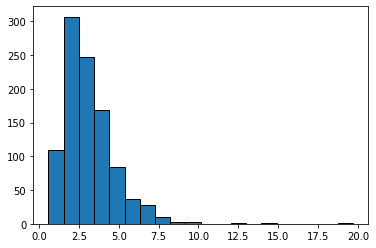

In [7]:
import math
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

#make this example reproducible
np.random.seed(1)

#generate dataset that contains 1000 log-normal distributed values
lognorm_dataset = lognorm.rvs(s=.5, scale=math.exp(1), size=1000)

#create histogram to visualize values in dataset
plt.hist(lognorm_dataset, edgecolor='black', bins=20)

(array([33.,  0.,  0., 12.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,
         1.,  2.,  2.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  2.,  0.,  1.,  1.,  3.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  0.,  2.,
         0.,  0.,  1.,  1.,  1.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

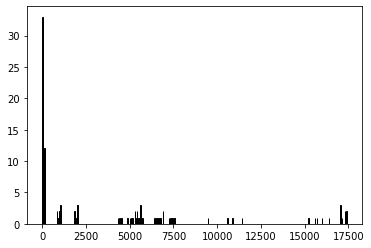

In [14]:
plt.hist(mgra_ds99[mgra_ds99['pop']>5000]['hhp'], edgecolor='black', bins=500)

In [9]:
mgra_ds99['pop']

0          41
1          81
2         111
3          73
4          63
         ... 
299021    196
299022      0
299023    307
299024    184
299025    262
Name: pop, Length: 299026, dtype: int64

Quantitative: 
- 